## Imports

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle
import pandas as pd

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


In [14]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [32]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [33]:
pk_delta_interp = pickle.load(open("interps/pks_delta_interp.p", "rb"))

In [34]:
#Get data for case with no recoupling
k = '1.0'
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])

    thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

In [35]:
# A_recs = [1e12, 10 ** (13.5), 1e15, 10 ** (16.5), 1e18]
# T_recs = [6e6, 6e5 * np.sqrt(10), 6e5, 6e4 * np.sqrt(10), 6e4]
# A_recs = A_recs[::-1]
# T_recs = T_recs[::-1]
# BM_KS = [str(round(n, 3)) for n in np.geomspace(0.1, 10, 100)]

N_points = 100  # Number of grid points in each dimension
A_rec_arr = np.logspace(12, 21, N_points)
T_rec_arr = np.logspace(np.log10(6e6), np.log10(6e3), N_points)

T_rec_arr = np.flip(T_rec_arr)[4:]
A_rec_arr = A_rec_arr[4:]

In [239]:
T_rec = T_rec_arr[0]

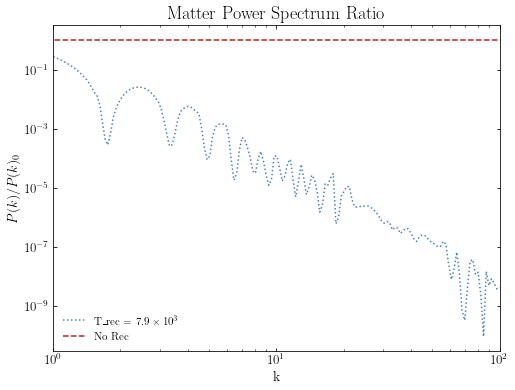

In [240]:
lines = ["-","--","-.",":"]
plt.plot(kk, pk_delta_interp((T_rec,kk))/Pks_no_rec,  ls = lines[i%len(lines)], label='T_rec = ' + scientific_format(T_rec))

plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1,1e2)
plt.legend()
plt.show()

In [36]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

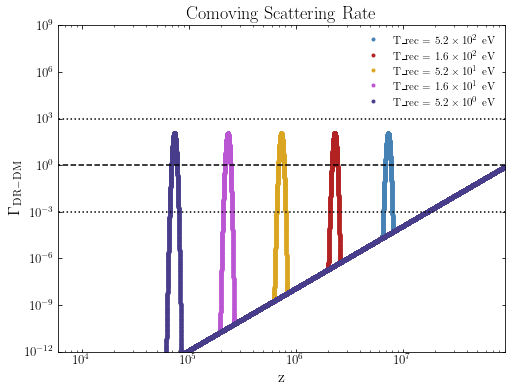

In [37]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

A_recs = [1e12, 10**(13.5), 1e15, 10**(16.5), 1e18]
T_recs = [6e6, 6e5*np.sqrt(10), 6e5, 6e4*np.sqrt(10), 6e4]

for i, T_rec in enumerate(T_recs):
    plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1e-3, T_rec=T_recs[i], sigma_fac=0.02), '.', label='T_rec = {} eV'.format(scientific_format(ktoev*T_recs[i])))

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e3,9e7)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [155]:
def plot_delta_recoupling(i):
    """
    Plot the rate and power spectrum for a given delta recoupling.
    """
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    T_rec = T_rec_arr[i]
    print(T_rec)
    pks_delta = pk_delta_interp((T_rec,kk))
    plt.plot(kk, pks_delta/Pks_no_rec,  ls = lines[i%len(lines)], label='T_rec = ' + scientific_format(T_rec))
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")

    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")

    zs = np.geomspace(1e-3,1e8,int(1e5))
    
    dmus = my_dmu_idm_dr(zs, np.flip(A_rec_arr)[i], a_idm_dr = 1e-3, T_rec=T_rec_arr[i], sigma_fac=0.01)
    plt.plot(
        zs,
        dmus,
        "b",
        label='T_rec = ' + scientific_format(T_rec))
    
    plt.plot([zs[-1],zs[0]], 1e-3 * np.ones(2), "--k")
    plt.plot([zs[-1],zs[0]], np.ones(2), "--k")

    plt.xlim(1e3, 1e8)
    plt.ylim(1e-10, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    plt.show()


In [29]:
path = "observation_data/"

dfDES = pd.read_csv(path + "DESY1.csv")
dfDES = dfDES.assign(
    ylow=dfDES["Y"] - dfDES["-DeltaY"], yhigh=dfDES["+DeltaY"] - dfDES["Y"]
)
dfDES = dfDES.assign(
    xlow=dfDES["X"] - dfDES["-DeltaX"], xhigh=dfDES["+DeltaX"] - dfDES["X"]
)
yerrDES = np.array([dfDES["ylow"], dfDES["yhigh"]])
xerrDES = np.array([dfDES["xlow"], dfDES["xhigh"]])

columns = ["k", "P(k)", "delta P(k)+", "delta P(k)-"]
dfBOSS = pd.read_csv(path + "BOSS.csv", header=None)
dfBOSS.columns = columns

dfBOSS = dfBOSS.assign(
    ylow=dfBOSS["P(k)"] - dfBOSS["delta P(k)-"],
    yhigh=dfBOSS["delta P(k)+"] - dfBOSS["P(k)"],
)
yerrBOSS = np.array([dfBOSS["ylow"], dfBOSS["yhigh"]])


In [30]:
#sort all relevant data by ks
constraint_ks = np.concatenate((dfBOSS["k"], dfDES["X"]))
constraint_pks = np.concatenate((dfBOSS["P(k)"], dfDES["Y"]))
constraint_pk_y_errs = np.concatenate((yerrBOSS, yerrDES), axis=1)
constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))]
constraint_pk_y_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))]
constraint_pk_y_var_sorted = constraint_pk_y_errs_sorted[0] + constraint_pk_y_errs_sorted[1]

# constraint_ks_sorted = constraint_ks_sorted[14:]
# constraint_pks_sorted = constraint_pks_sorted[14:]
# constraint_pk_y_var_sorted = constraint_pk_y_var_sorted[14:]

In [48]:
test_pks = np.zeros(len(constraint_ks_sorted))

for i, k in enumerate(constraint_ks_sorted):
    test_pks[i] = pk_delta_interp((T_rec_arr[25],k))

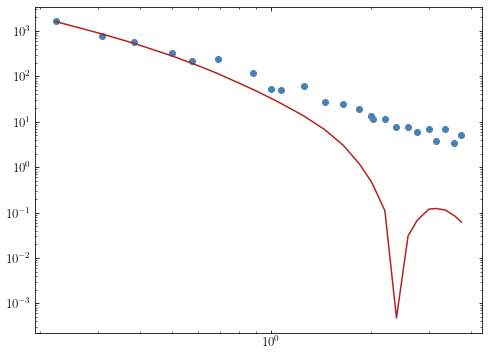

In [49]:
plt.loglog(constraint_ks_sorted, constraint_pks_sorted, 'o')
plt.loglog(constraint_ks_sorted, test_pks)
plt.show()

In [268]:
len(constraint_ks_sorted)

24

In [346]:
def make_constraint_chisquare():
    chi2_grid = []
    chi2_Ts = []

    for i, Tr in enumerate(T_rec_arr):
        test_pks = np.array([pk_delta_interp((Tr,k)) for k in constraint_ks_sorted])
        chi2 = np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2)
        chi2_grid.append(chi2)
        chi2_Ts.append(Tr)
    return np.array(chi2_grid), np.array(chi2_Ts)

def make_constraint_grid_chisquare(chi2_grid, crit_val = 36.42):
    #crit_val = 36.42 #for 24 points
    limit_grid = np.zeros(len(chi2_grid))
    for i in range(len(limit_grid)):
        if chi2_grid[i] > crit_val:
            limit_grid[i] = 1
    return limit_grid


In [347]:
chi2_grid,chi2_Ts = make_constraint_chisquare()

In [348]:
limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid)

In [398]:
crit_idx = np.max(np.where(limit_grid_chi2==1))
print("Critical temperature is Log10(T) = {}".format(round(np.log10(T_rec_arr[crit_idx]),2)))
dmus = my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1e-3, T_rec=T_recs[i], sigma_fac=0.02)
print("Peak recoupling stregnth = {}".format(dmus[argrelextrema(dmus, np.greater)[0][0]]))


Critical temperature is Log10(T) = 4.81
Peak recoupling stregnth = 115.6475225467316


In [370]:
chi2_grid_pruned = chi2_grid[abs(chi2_grid - 4.89) > 0.1][9:]
chi2_Ts_pruned = chi2_Ts[abs(chi2_grid - 4.89) > 0.1][9:]

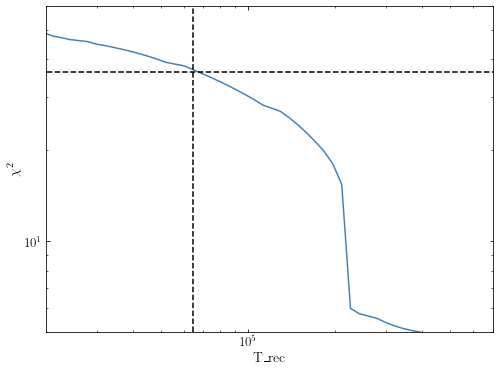

In [386]:
plt.loglog(chi2_Ts_pruned, chi2_grid_pruned)
plt.hlines(36.42, 1e4, 1e6, 'k', '--')
plt.vlines(T_rec_arr[crit_idx], 5e0, 1e2, 'k', '--')
plt.xlim(2e4, 7e5)
plt.ylim(5e0, 6e1)
plt.xlabel("T_rec")
plt.ylabel(r"$\chi^2$")
plt.savefig('Figures/chi2_delta_constraint.pdf')
plt.show()

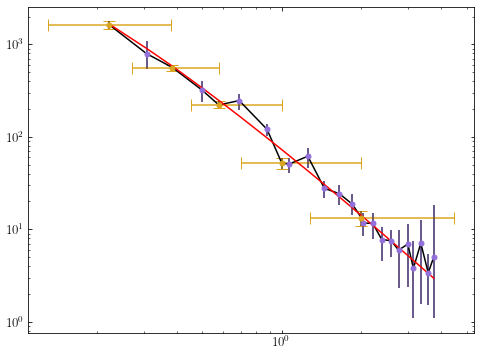

In [339]:
plt.errorbar(
    dfBOSS["k"],
    dfBOSS["P(k)"],
    yerr=yerrBOSS,
    marker="o",
    ms=5,
    color="mediumpurple",
    ls="none",
    label=r"BOSS DR9 Ly-$\alpha$ forest",
)
plt.errorbar(
    dfDES["X"],
    dfDES["Y"],
    yerr=yerrDES,
    xerr=xerrDES,
    marker="o",
    ms=5,
    color="goldenrod",
    ls="none",
    capsize=6,
    label="DES Y1 cosmic Shear",
)

plt.plot(constraint_ks_sorted, constraint_pks_sorted, color="black", label="Constraint")
plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_errs_sorted, color="black", ls="none", alpha=0.5)

plt.plot(constraint_ks_sorted, test_pks, color="red", label="Test")

plt.xscale("log")
plt.yscale("log")

In [15]:
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    z_data = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
    thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)
    a_data = 1/(1+z_data)
    a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
    aprime = a.derivative()

In [24]:
z_crit = 10**(4.8)/(2.73*0.3)

In [25]:
aprime(thermo_taus(z_crit))/a(thermo_taus(z_crit))
#Comoving hubble at z_crit

0.17019224906376643

In [26]:
z_crit = 10**(4.8)/(2.73)

In [50]:
#k_kinetic decoupling from equation 30 of https://arxiv.org/pdf/astro-ph/0503387.pdf
3.76e7 *(1e3/(100*1e9))**(1/2) *(10**(4.8)*ktoev/(30*1e6))**(1/2)
#This lines up with the rough value of k at which we're suppressed for 10**(4.8) recoupling!

1.6007106110386495

In [28]:
1e-2/(aprime(thermo_taus(z_crit))/a(thermo_taus(z_crit)))

0.18687817207459445